In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pytz

from fps_dfs_optimizer.src.draftkings_tools import get_players_from_salaries
from fps_dfs_optimizer.src.draftkings_tools import EntriesHandler
from fps_dfs_optimizer.src.optimizer import Reoptimizer

In [2]:
df_players = get_players_from_salaries(
    '../data/raw/xDKSalaries_20210126.csv', 
    tz='US/Eastern'
)

In [3]:
df_game_summary = df_players.groupby('Game').first()[['Time']].reset_index().sort_values(by='Time')
df_game_summary

,Game,Time
0,LAC @ ATL,2021-01-27 00:30:00+00:00
2,WAS @ HOU,2021-01-27 01:00:00+00:00
1,NY @ UTA,2021-01-27 02:00:00+00:00


In [4]:
time = dt.datetime.now(pytz.UTC)

## If testing, run the next code block to change the time

In [5]:
time = time.replace(month=1, day=27, hour=1, minute=30)

In [6]:
df_game_summary['Locked'] = df_game_summary['Time'] < time
df_game_summary

,Game,Time,Locked
0,LAC @ ATL,2021-01-27 00:30:00+00:00,True
2,WAS @ HOU,2021-01-27 01:00:00+00:00,True
1,NY @ UTA,2021-01-27 02:00:00+00:00,False


In [7]:
df_players['locked'] = df_players['Time'] < time

In [8]:
df_players[df_players['projections']==0]['min_exp'] = 0

In [9]:
sheet_name = 'DKEntries_Test_gen.csv'
entries = EntriesHandler('../data/raw/' + sheet_name, df_players, read_lineups=True)

`infer_max_exposure()` is a utility function that just infers the exposure from the sheet being read this will replace whatever is in `entries.df['max_exp']`

In [10]:
entries.infer_max_exps()

In [11]:
reopt = Reoptimizer(
    entries, 
    verbose=False,
    timelimit=20, 
    mipgap=0.002, 
    visualize=True
)

In [12]:
reopt.initialize()

Unfilled spots remaining: 216


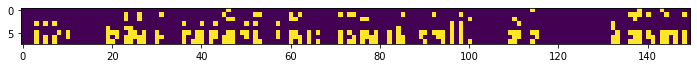



Cutoff set to 0.95; 10 variables converted to binaries


Unfilled spots remaining: 66


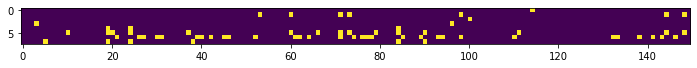



Cutoff set to 0.9; 5 variables converted to binaries


Unfilled spots remaining: 56


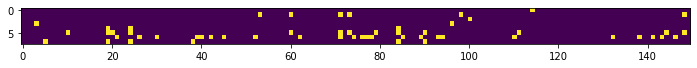



Cutoff set to 0.85; 11 variables converted to binaries


Unfilled spots remaining: 52


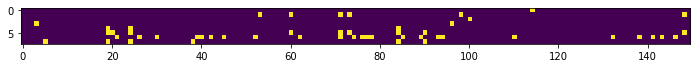



Cutoff set to 0.8; 7 variables converted to binaries


Unfilled spots remaining: 45


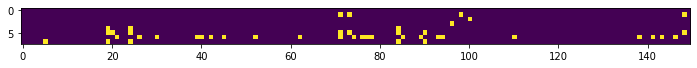



Cutoff set to 0.75; 9 variables converted to binaries


Unfilled spots remaining: 38


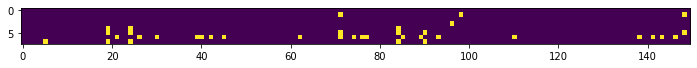



Cutoff set to 0.7; 7 variables converted to binaries


Unfilled spots remaining: 33


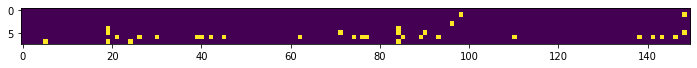



Cutoff set to 0.6499999999999999; 6 variables converted to binaries


Unfilled spots remaining: 28


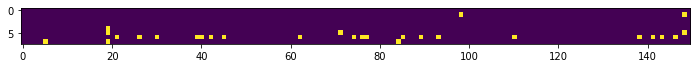



Cutoff set to 0.6; 4 variables converted to binaries


Unfilled spots remaining: 24


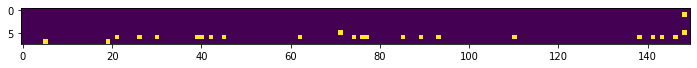



Cutoff set to 0.55; 14 variables converted to binaries


Unfilled spots remaining: 23


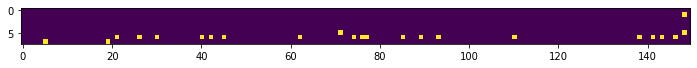



Cutoff set to 0.5; 19 variables converted to binaries


Unfilled spots remaining: 18


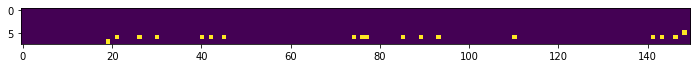



Cutoff set to 0.44999999999999996; 12 variables converted to binaries


Unfilled spots remaining: 11


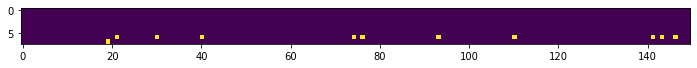



Cutoff set to 0.3999999999999999; 7 variables converted to binaries


Unfilled spots remaining: 5


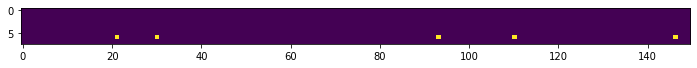



Cutoff set to 0.35; 8 variables converted to binaries


Unfilled spots remaining: 4


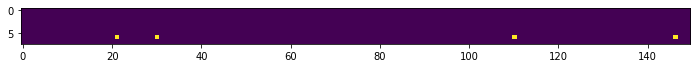



Cutoff set to 0.29999999999999993; 0 variables converted to binaries


Unfilled spots remaining: 0


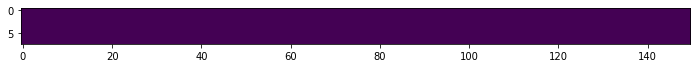

In [13]:
reopt.solve()

In [14]:
reopt.summarize()[:60]

,Before,After,Difference
Rudy Gobert,0.613333,0.693333,0.080000
RJ Barrett,0.426667,0.373333,-0.053333
Joe Ingles,0.420000,0.473333,0.053333
Immanuel Quickley,0.100000,0.053333,-0.046667
Bojan Bogdanovic,0.053333,0.093333,0.040000
Alec Burks,0.466667,0.440000,-0.026667
Julius Randle,0.273333,0.246667,-0.026667
Mike Conley,0.286667,0.273333,-0.013333
Donovan Mitchell,0.053333,0.046667,-0.006667
Obi Toppin,0.000000,0.006667,0.006667


## Pre-reopt summary

In [15]:
print('Average lineup projected score: {:.2f}'.format(
    entries.map_to_col('projections').sum(axis=1).sum()/len(entries.df_entries))
)
print('Average lineup salary: {:.2f}'.format(
    entries.map_to_col('Salary').sum(axis=1).sum()/len(entries.df_entries))
)

Average lineup projected score: 268.18
Average lineup salary: 49883.33


## Post-reopt summary

In [16]:
entries.add_lineups_to_entries(reopt.df_optimal, drop_entries=True, version='reopt')

print('Average lineup projected score: {:.2f}'.format(
    entries.map_to_col('projections').sum(axis=1).sum()/len(entries.df_entries))
)
print('Average lineup salary: {:.2f}'.format(
    entries.map_to_col('Salary').sum(axis=1).sum()/len(entries.df_entries))
)

Average lineup projected score: 267.94
Average lineup salary: 49767.33
